In [34]:
import yfinance as yf 
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout 
from keras.optimizers import Adam
from math import sqrt

In [35]:
#Defining the list of stock tickers
tickers = ["AMZN", "META", "GOOGL"]

#Definng the start and end dates
start_date = dt.datetime.now() - dt.timedelta(days = 6*365)
end_date = dt.datetime.now()

#Here we will fetch the data from yfinance and store it in a dictionary

stock_data = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    stock_data[ticker] = stock.history(start = start_date, end = end_date).dropna()

#Concatenate the stock data obtained into one dataframe
data = pd.concat(stock_data.values(), axis =1, keys= stock_data.keys())

data.index = pd.to_datetime(data.index)
print(data.head())
data.describe()

                                AMZN                                   \
                                Open       High        Low      Close   
Date                                                                    
2017-04-18 00:00:00-04:00  45.049500  45.480499  45.039001  45.188999   
2017-04-19 00:00:00-04:00  45.391998  45.525002  44.868500  44.959999   
2017-04-20 00:00:00-04:00  44.985001  45.265999  44.814499  45.103001   
2017-04-21 00:00:00-04:00  45.133499  45.182499  44.838501  44.926498   
2017-04-24 00:00:00-04:00  45.433998  45.499500  45.191002  45.370499   

                                                                  META  \
                             Volume Dividends Stock Splits        Open   
Date                                                                     
2017-04-18 00:00:00-04:00  59984000       0.0          0.0  141.270004   
2017-04-19 00:00:00-04:00  57404000       0.0          0.0  141.350006   
2017-04-20 00:00:00-04:00  56288000       0.0

AMZN                                                       \
              Open         High          Low        Close        Volume   
count  1509.000000  1509.000000  1509.000000  1509.000000  1.509000e+03   
mean    110.637568   111.951195   109.174696   110.580030  8.379296e+07   
std      39.580556    40.065901    39.043980    39.519197  3.992973e+07   
min      44.985001    45.182499    44.814499    44.926498  1.762600e+07   
25%      84.150002    85.250000    83.167000    84.310997  5.734200e+07   
50%      96.935501    97.940002    95.650002    97.145500  7.204200e+07   
75%     154.913498   156.644501   151.856995   154.474503  9.858200e+07   
max     187.199997   188.654007   184.839493   186.570496  3.313000e+08   

                                     META                            ...  \
      Dividends Stock Splits         Open         High          Low  ...   
count    1509.0  1509.000000  1509.000000  1509.000000  1509.000000  ...   
mean        0.0     0.013254   209.589821   212.416832   206.887654  ...   
std         0.0     0.514856    64.307783    64.957187    63.597085  ...   
min         0.0     0.000000    90.080002    90.459999    88.089996  ...   
25%         0.0     0.000000   167.160004   169.289993   164.809998  ...   
50%         0.0     0.000000   187.029999   189.479996   184.779999  ...   
75%         0.0     0.000000   249.039993   252.800003   246.610001  ...   
max         0.0    20.000000   381.679993   384.329987   378.809998  ...   

                                                  GOOGL               \
             Volume Dividends Stock Splits         Open         High   
count  1.509000e+03    1509.0       1509.0  1509.000000  1509.000000   
mean   2.356225e+07       0.0          0.0    81.861575    82.766186   
std    1.632819e+07       0.0          0.0    30.725185    31.067556   
min    6.046300e+06       0.0          0.0    42.626999    42.869499   
25%    1.455080e+07       0.0          0.0    55.958500    56.643002   
50%    1.946500e+07       0.0          0.0    70.781998    71.725502   
75%    2.745080e+07       0.0          0.0   104.985497   106.300003   
max    2.323166e+08       0.0          0.0   151.250000   151.546494   

                                                                      
               Low        Close        Volume Dividends Stock Splits  
count  1509.000000  1509.000000  1.509000e+03    1509.0  1509.000000  
mean     80.970881    81.892986  3.516259e+07       0.0     0.013254  
std      30.343411    30.702739  1.588905e+07       0.0     0.514856  
min      42.562500    42.699501  9.312000e+06       0.0     0.000000  
25%      55.423500    55.981499  2.519000e+07       0.0     0.000000  
50%      69.730003    70.662003  3.112600e+07       0.0     0.000000  
75%     103.856499   105.019997  4.008000e+07       0.0     0.000000  
max     148.899002   149.838501  1.331780e+08       0.0    20.000000  

[8 rows x 21 columns]

This code snippet defines a list of stock tickers to fetch historical data for and retrieves that data using the yfinance library. The tickers include Amazon (AMZN), Apple (AAPL), Microsoft (MSFT), Meta Platforms (META), and Google (GOOGL).

The code defines a start and end date for the data fetch, where the start date is 6 years before the current date. The historical stock data is fetched using the yf.Ticker() function for each ticker, and the fetched data is stored in a dictionary called stock_data. The .history() method is used to fetch the data for the given date range, and any missing values are dropped using .dropna().

Finally, the individual stock data is concatenated into a single DataFrame called data using pd.concat() with the axis set to 1, meaning the concatenation occurs column-wise. The dictionary keys are used as higher-level column labels to differentiate between different stocks. The index is converted to a datetime format for easier handling of time-series data. The code then prints the first few rows of the DataFrame using .head() and provides summary statistics for the dataset using .describe().

In summary, this code snippet fetches historical stock data for a list of tickers using the yfinance library, concatenates the data into a single DataFrame, and provides an overview of the dataset.

In [36]:
#Calculating the total values in the dataset
total = data.size
print(f'Total values- {total}')

#Check for null values in the dataset
null= data.isnull() 
total_null = null.sum().sum()
print(f'total number of null values : {total_null}')

#to veiw the whole datset we will covert the obtained data into a csv file 
data.to_csv("combinedData.csv")


Total values- 31689
total number of null values : 0


In summary, this code snippet calculates the total number of values in the DataFrame, checks for null values, and exports the DataFrame to a CSV file for easier viewing and further analysis.

We can see from the above output that the total number of null values in our dataset is zero, meaning we can now procees to the next step - analysis of our data and adding technical indicators for better analysis

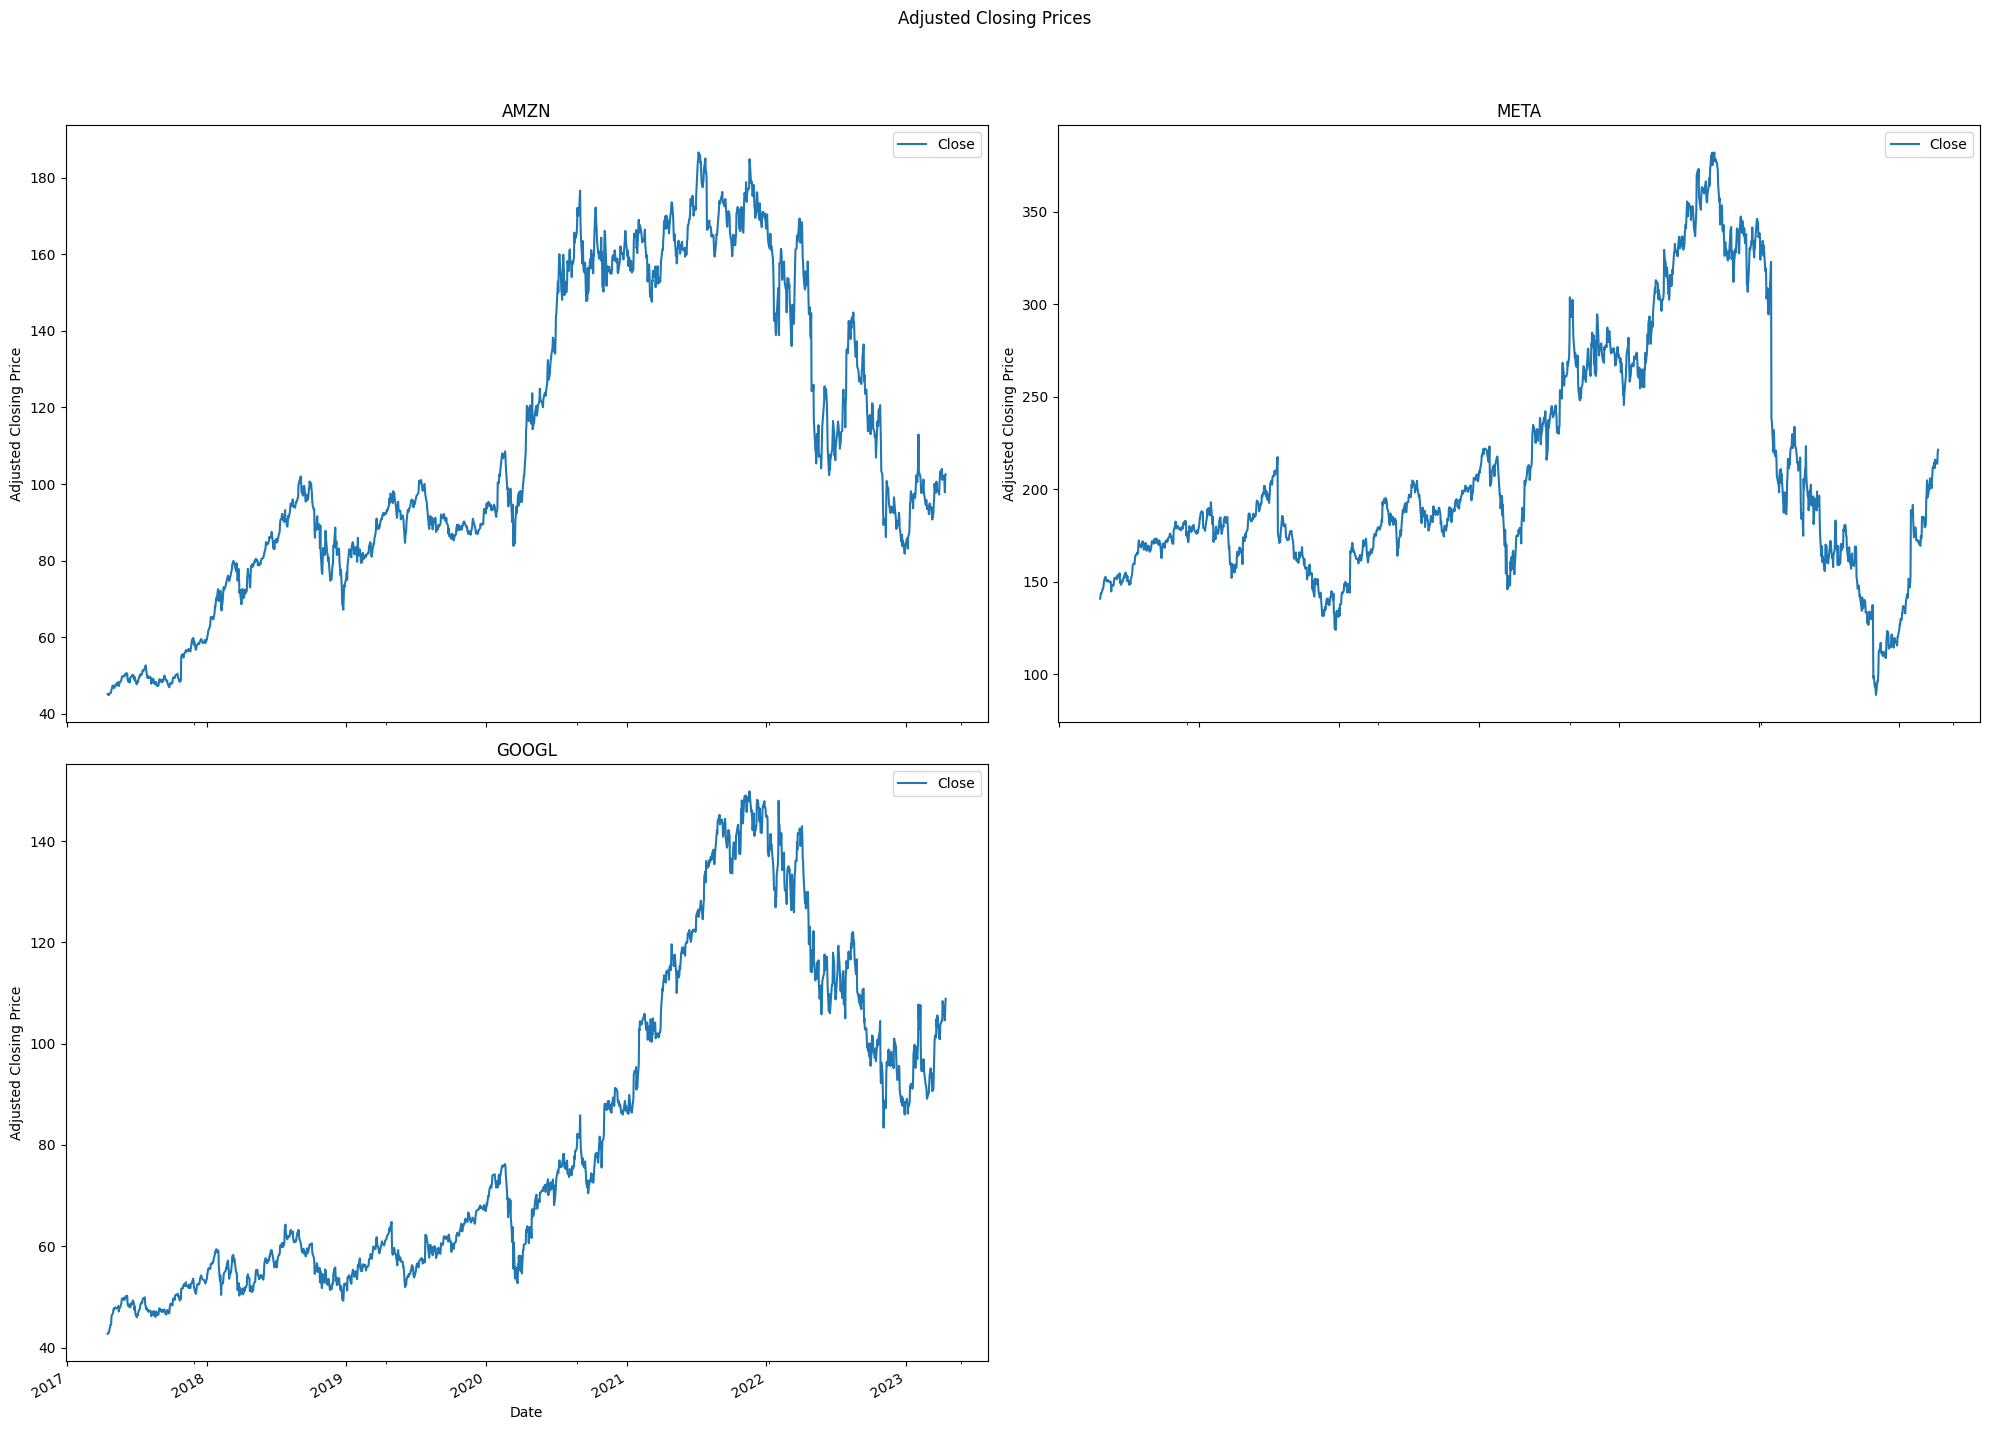

In [37]:
#Here we will plot the Closing prices for each company to see there trends over the last 6 years

AdjClose = data.loc[:,(slice(None), 'Close')] # Extracting adj close prices
numrows = len(tickers) // 2 + len(tickers) % 2 # defining number of rows and columns for the subplots
numcols = 2

fig, axs = plt.subplots(nrows= numrows, ncols = numcols, figsize = (20,15), sharex = True)
fig.suptitle('Adjusted Closing Prices')

axs_flat = axs.flatten() #this will convert 2d axes array to 1d for easier iteration over the axes

for i, ticker in enumerate(tickers):
    AdjClose[ticker].plot(ax=axs_flat[i], title = ticker)
    axs_flat[i].set_xlabel('Date')
    axs_flat[i].set_ylabel('Adjusted Closing Price')

# Remove the extra unused subplot
fig.delaxes(axs_flat[-1])

#layout spacing
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

 

Observations from the above graphs obtained:
1. The adjusted closing prices for each company have increased over time especially between the time period 2020-2021 (Covid 19)
2. We can see a sudden downtrend between the time period 2022-2023 for META.
3. Google has generally had the highest adjusted closing prices among the five companies, while Meta (formerly Facebook) has generally had the lowest.
4. Apple's adjusted closing prices appear to be the most volatile, with more frequent spikes and dips compared to the other companies.
5. (Inflection Points) There are some periods of time where the adjusted closing prices for all five companies move in the same direction, such as during market-wide trends or events (for example during covid-19). Conversely, there may be other periods where the companies' prices move in opposite directions or have different levels of volatility.

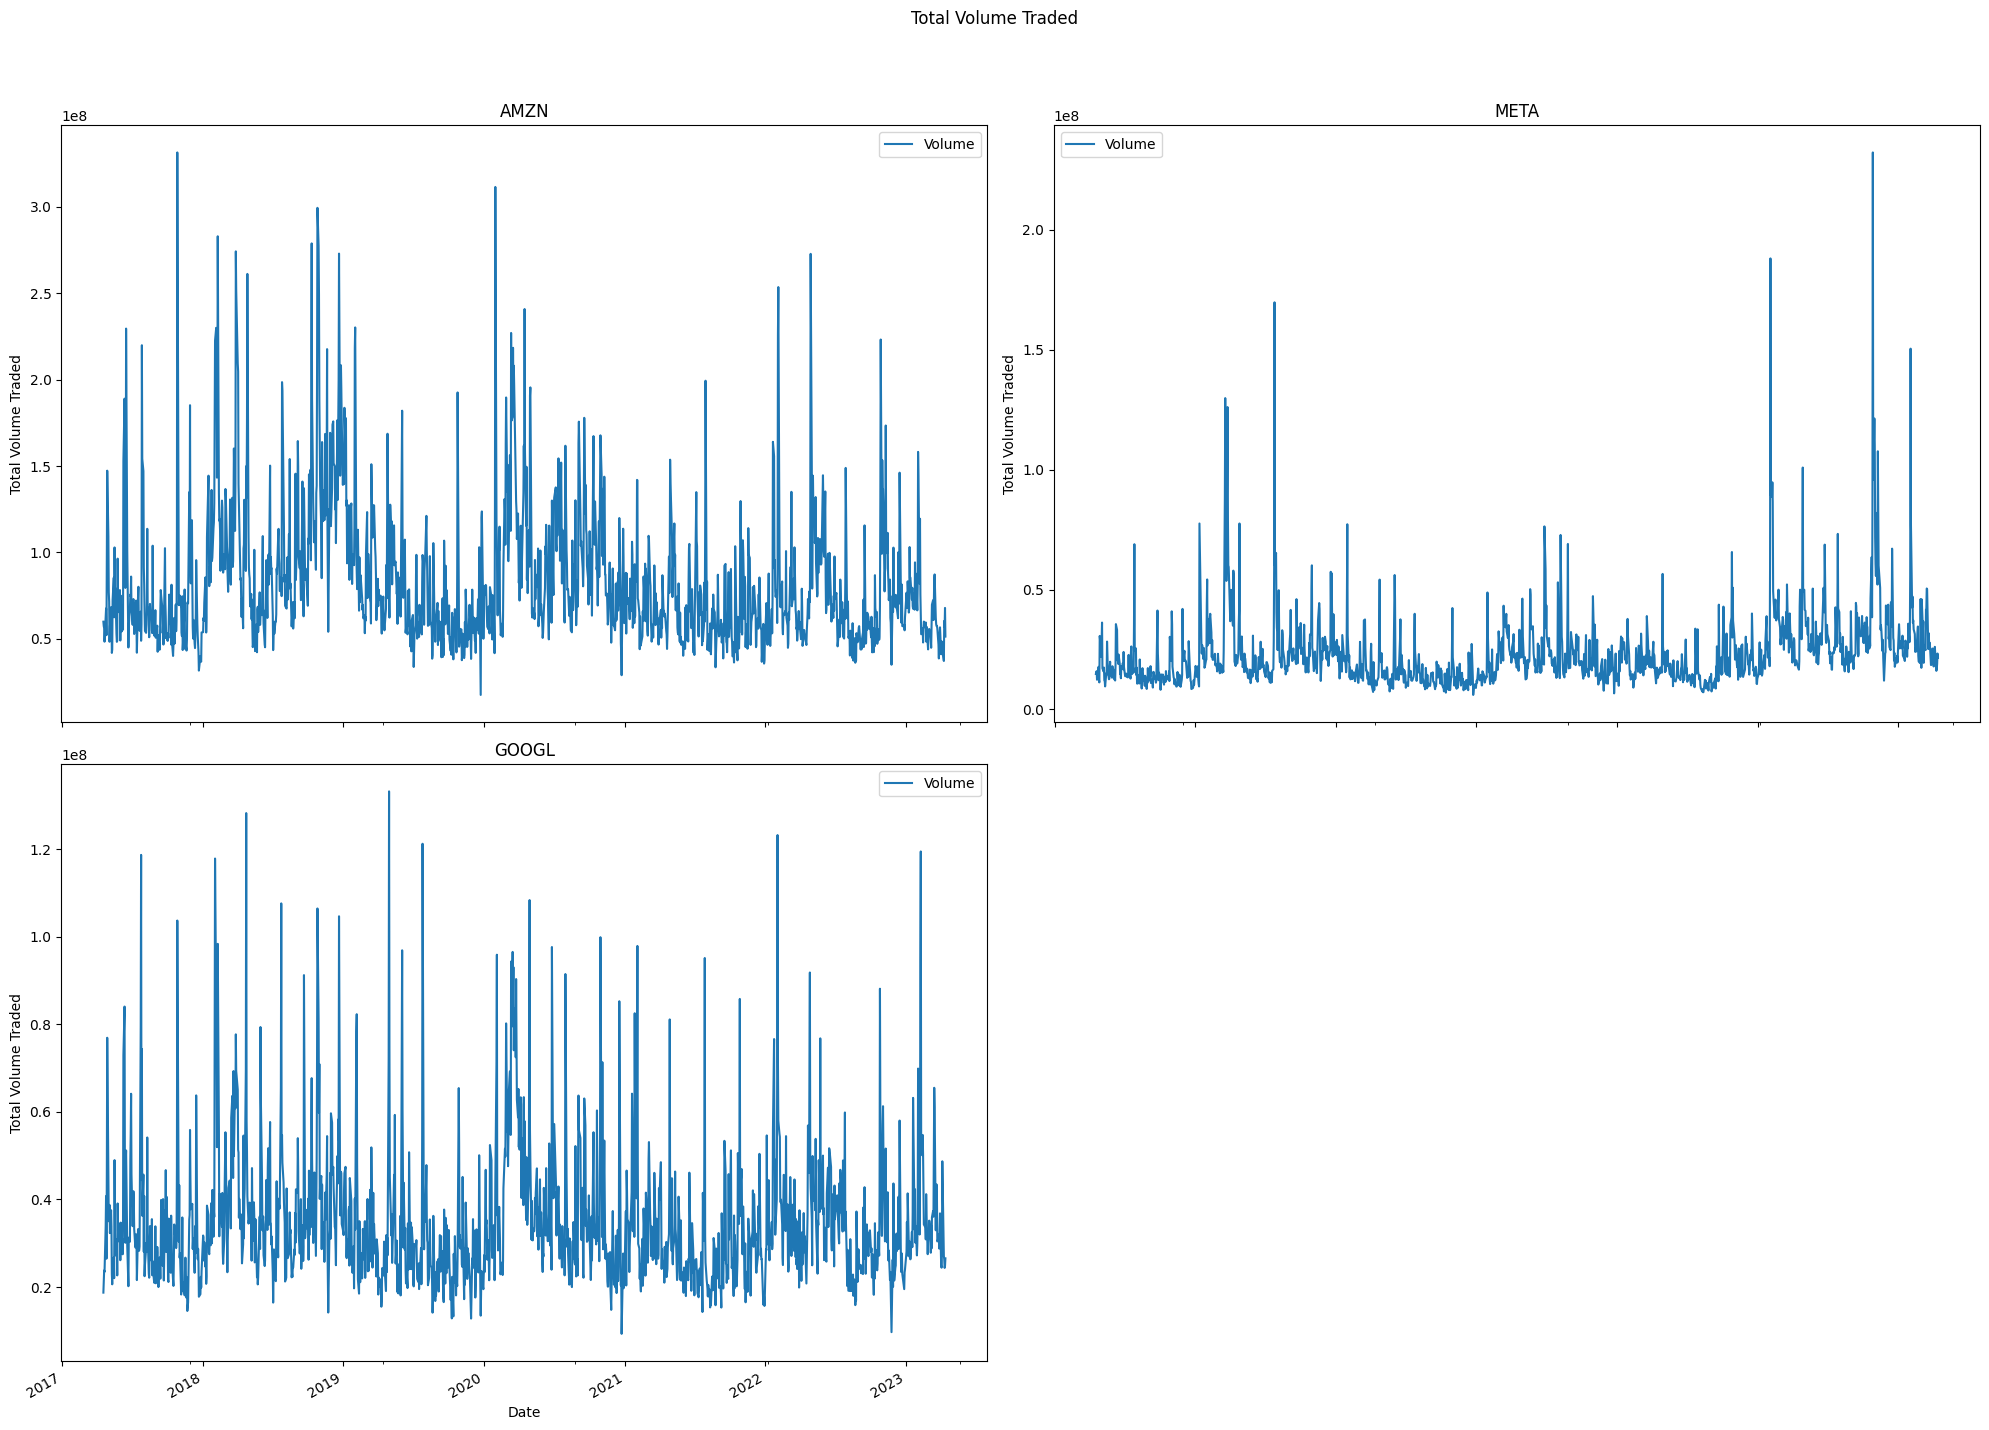

In [38]:
#If we want to analyse the total volume of the stock traded we can do that by plotting it 

VolTraded = data.loc[:,(slice(None), 'Volume')]
numrows = len(tickers) // 2 + len(tickers) % 2 # defining number of rows and columns for the subplots
numcols = 2

fig, axs = plt.subplots(nrows= numrows, ncols = numcols, figsize = (20,15), sharex = True)
fig.suptitle('Total Volume Traded')

axs_flat = axs.flatten() #this will convert 2d axes array to 1d for easier iteration over the axes

for i, ticker in enumerate(tickers):
    VolTraded[ticker].plot(ax=axs_flat[i], title = ticker)
    axs_flat[i].set_xlabel('Date')
    axs_flat[i].set_ylabel('Total Volume Traded')

# Remove the extra unused subplot
fig.delaxes(axs_flat[-1])

#layout spacing
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


1. The above plots shows us the total volume traded for company over a specific date range.
2. The sudden spikes and drops in the above plots shows the important market events that impacted the comapnies correspondingly.
3. We can compare the relative liquidity of each stock, the higher average trading volumes are considered more liquid indicating that it is much easier to sell or buy the shares without having an impact on the stock price.

Calculating Moving Average of the Adjusted Closing Prices for the companies 

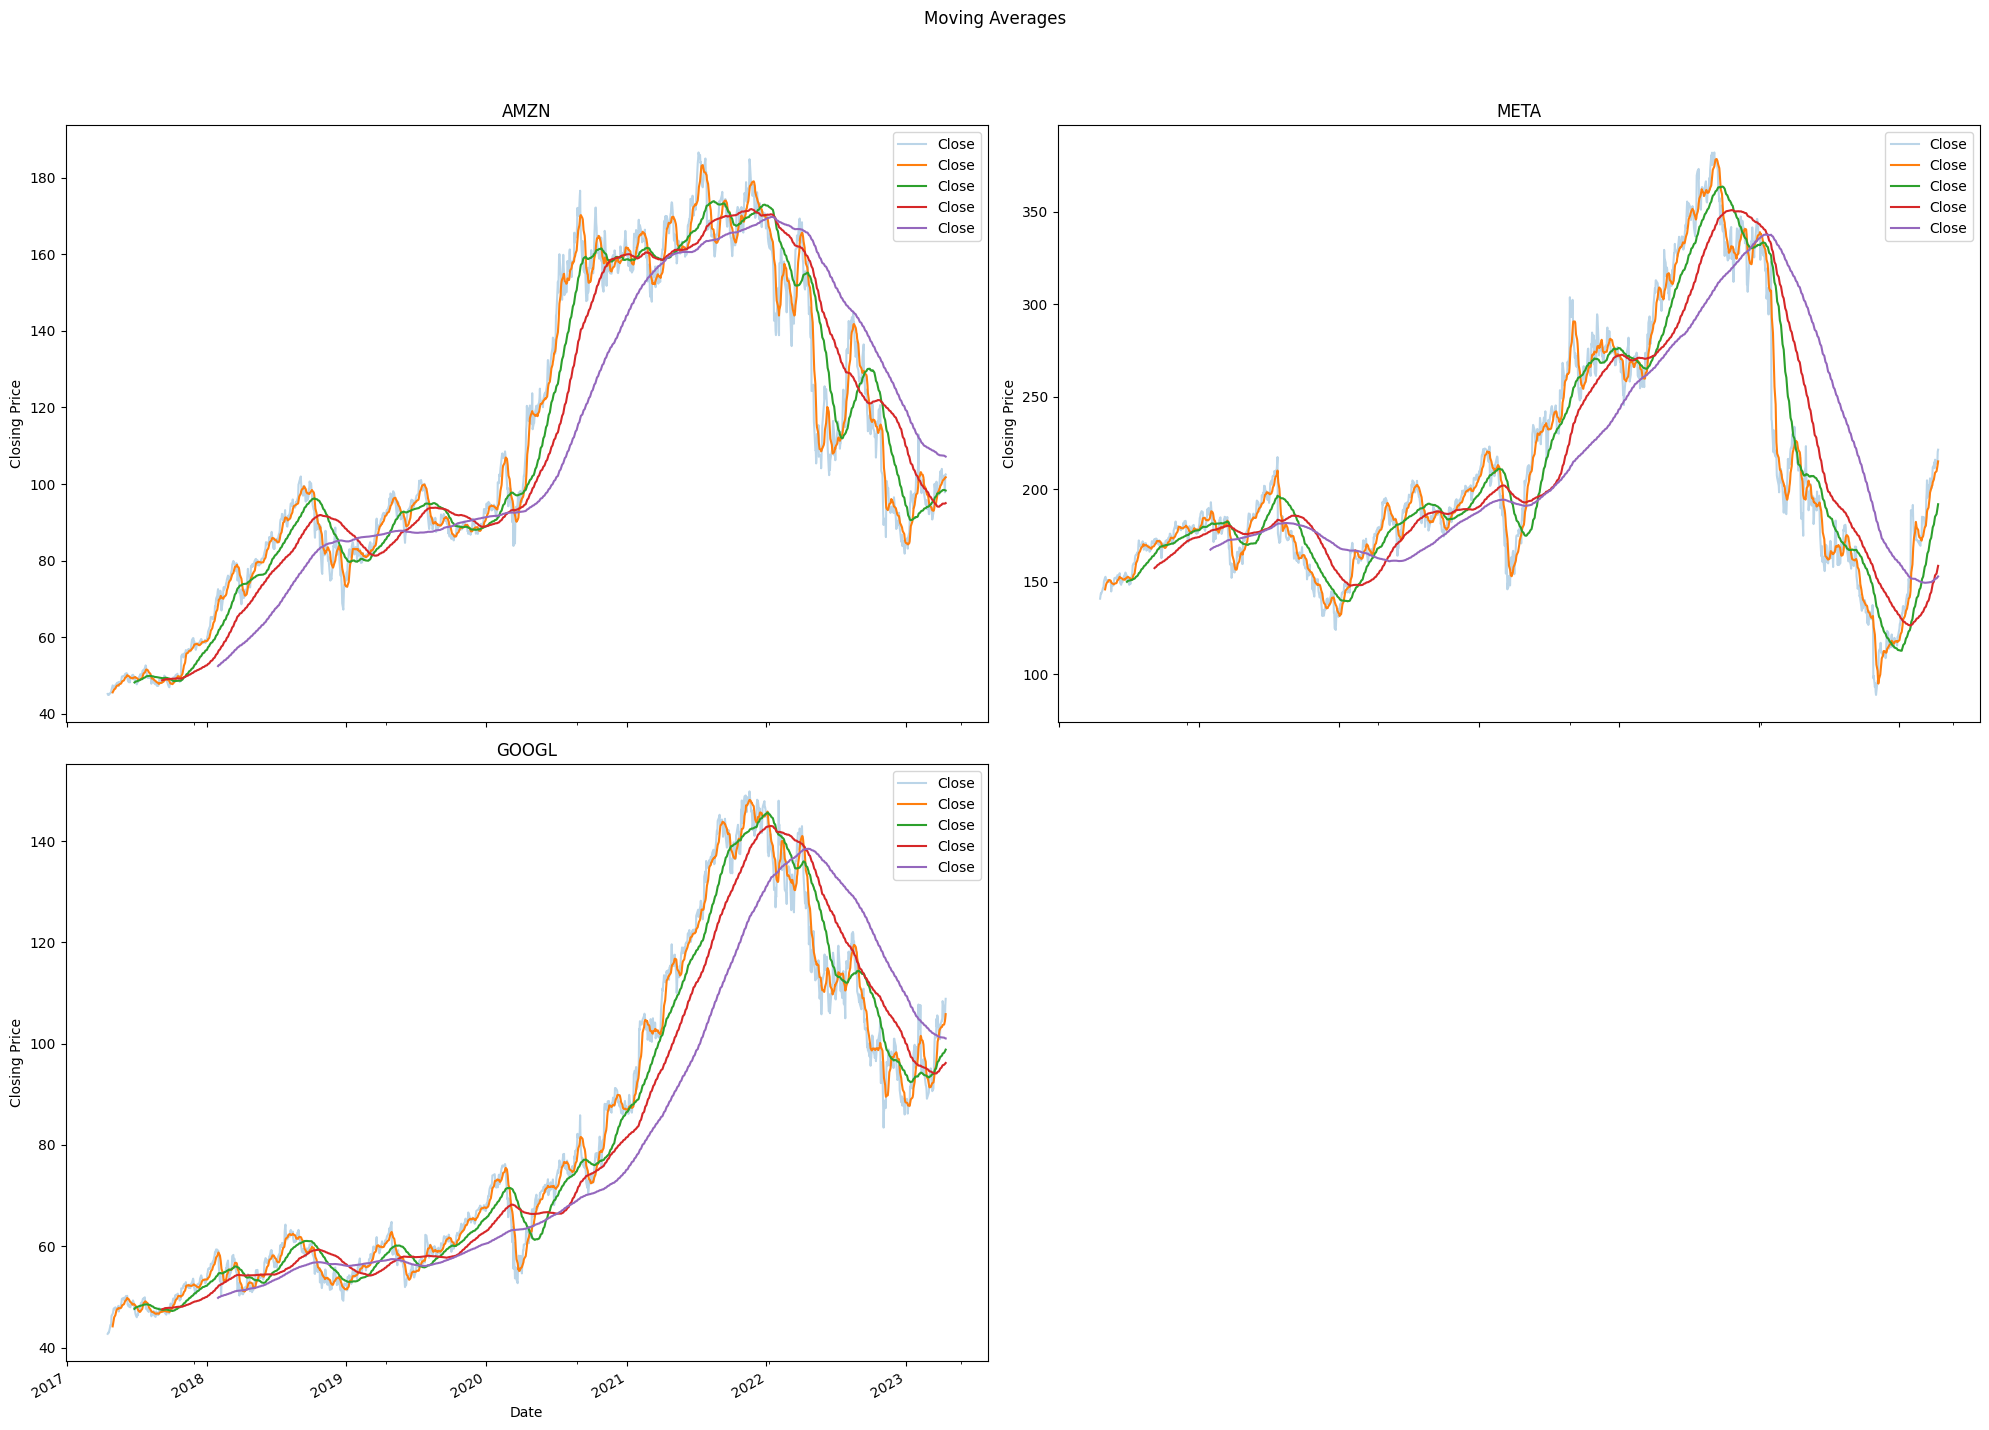

In [39]:
 # Calculate the moving averages of the Closing price
MA = [10, 50, 100, 200]
AdjClose = data.loc[:, (slice(None), 'Close')]

# Define the number of rows and columns for the subplots
numrows = len(tickers) // 2 + len(tickers) % 2
numcols = 2

fig, axs = plt.subplots(nrows=numrows, ncols=numcols, figsize=(20, 15), sharex=True)
fig.suptitle('Moving Averages')

# Loop through each ticker
for i, ticker in enumerate(tickers):
    ax = axs[i // numcols, i % numcols]
    
    # Plot the original closing prices
    AdjClose[ticker].plot(ax=ax, alpha=0.3, label='Closing Price')

    # Calculate and plot the moving averages
    for ma in MA:
        ma_series = AdjClose[ticker].rolling(window=ma).mean()
        ma_series.plot(ax=ax, label=f'MA {ma} days')

    ax.set_title(ticker)
    ax.set_xlabel('Date')
    ax.set_ylabel('Closing Price')
    ax.legend()

# Remove the extra unused subplot
axs[-1, -1].axis('off')

# Adjust layout for better spacing
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


This code snippet calculates and plots the moving averages (MA) of the closing prices for the specified stock tickers, along with the original closing prices. The moving averages are calculated for 10, 50, 100, and 200-day windows.

The code first extracts the adjusted closing price for each stock into a new DataFrame called AdjClose by selecting the 'Close' columns for all tickers using .loc[].
It sets the number of rows and columns for the subplots based on the number of tickers.
The code creates a figure with multiple subplots using plt.subplots(), sharing the x-axis and setting an appropriate figure size.
It then loops through each ticker and creates a subplot for each:
a. The original adjusted closing prices are plotted with an alpha value of 0.3 (for transparency).
b. For each moving average window (10, 50, 100, and 200 days), the code calculates the rolling mean using .rolling(window=ma).mean() and plots the result on the same subplot.
c. The subplot is labeled with the ticker name, axis labels, and a legend.
The last unused subplot is removed with axs[-1, -1].axis('off').
The layout is adjusted for better spacing using fig.tight_layout(), and the figure is displayed with plt.show()

1. Calculating moving average helps us to understand the overall trend of the stock price, rising moving average indicates an uptrend and vica versa
2. When a stock price is above the moving average it signifies that the stocks can be bought that is it acts as support level whereas if the stock price approaches from below it indicates resistance from the moving average.

Calculating the RSI(Relative Strength Indicator) and Moving Average Convergence Divergence (MACD)

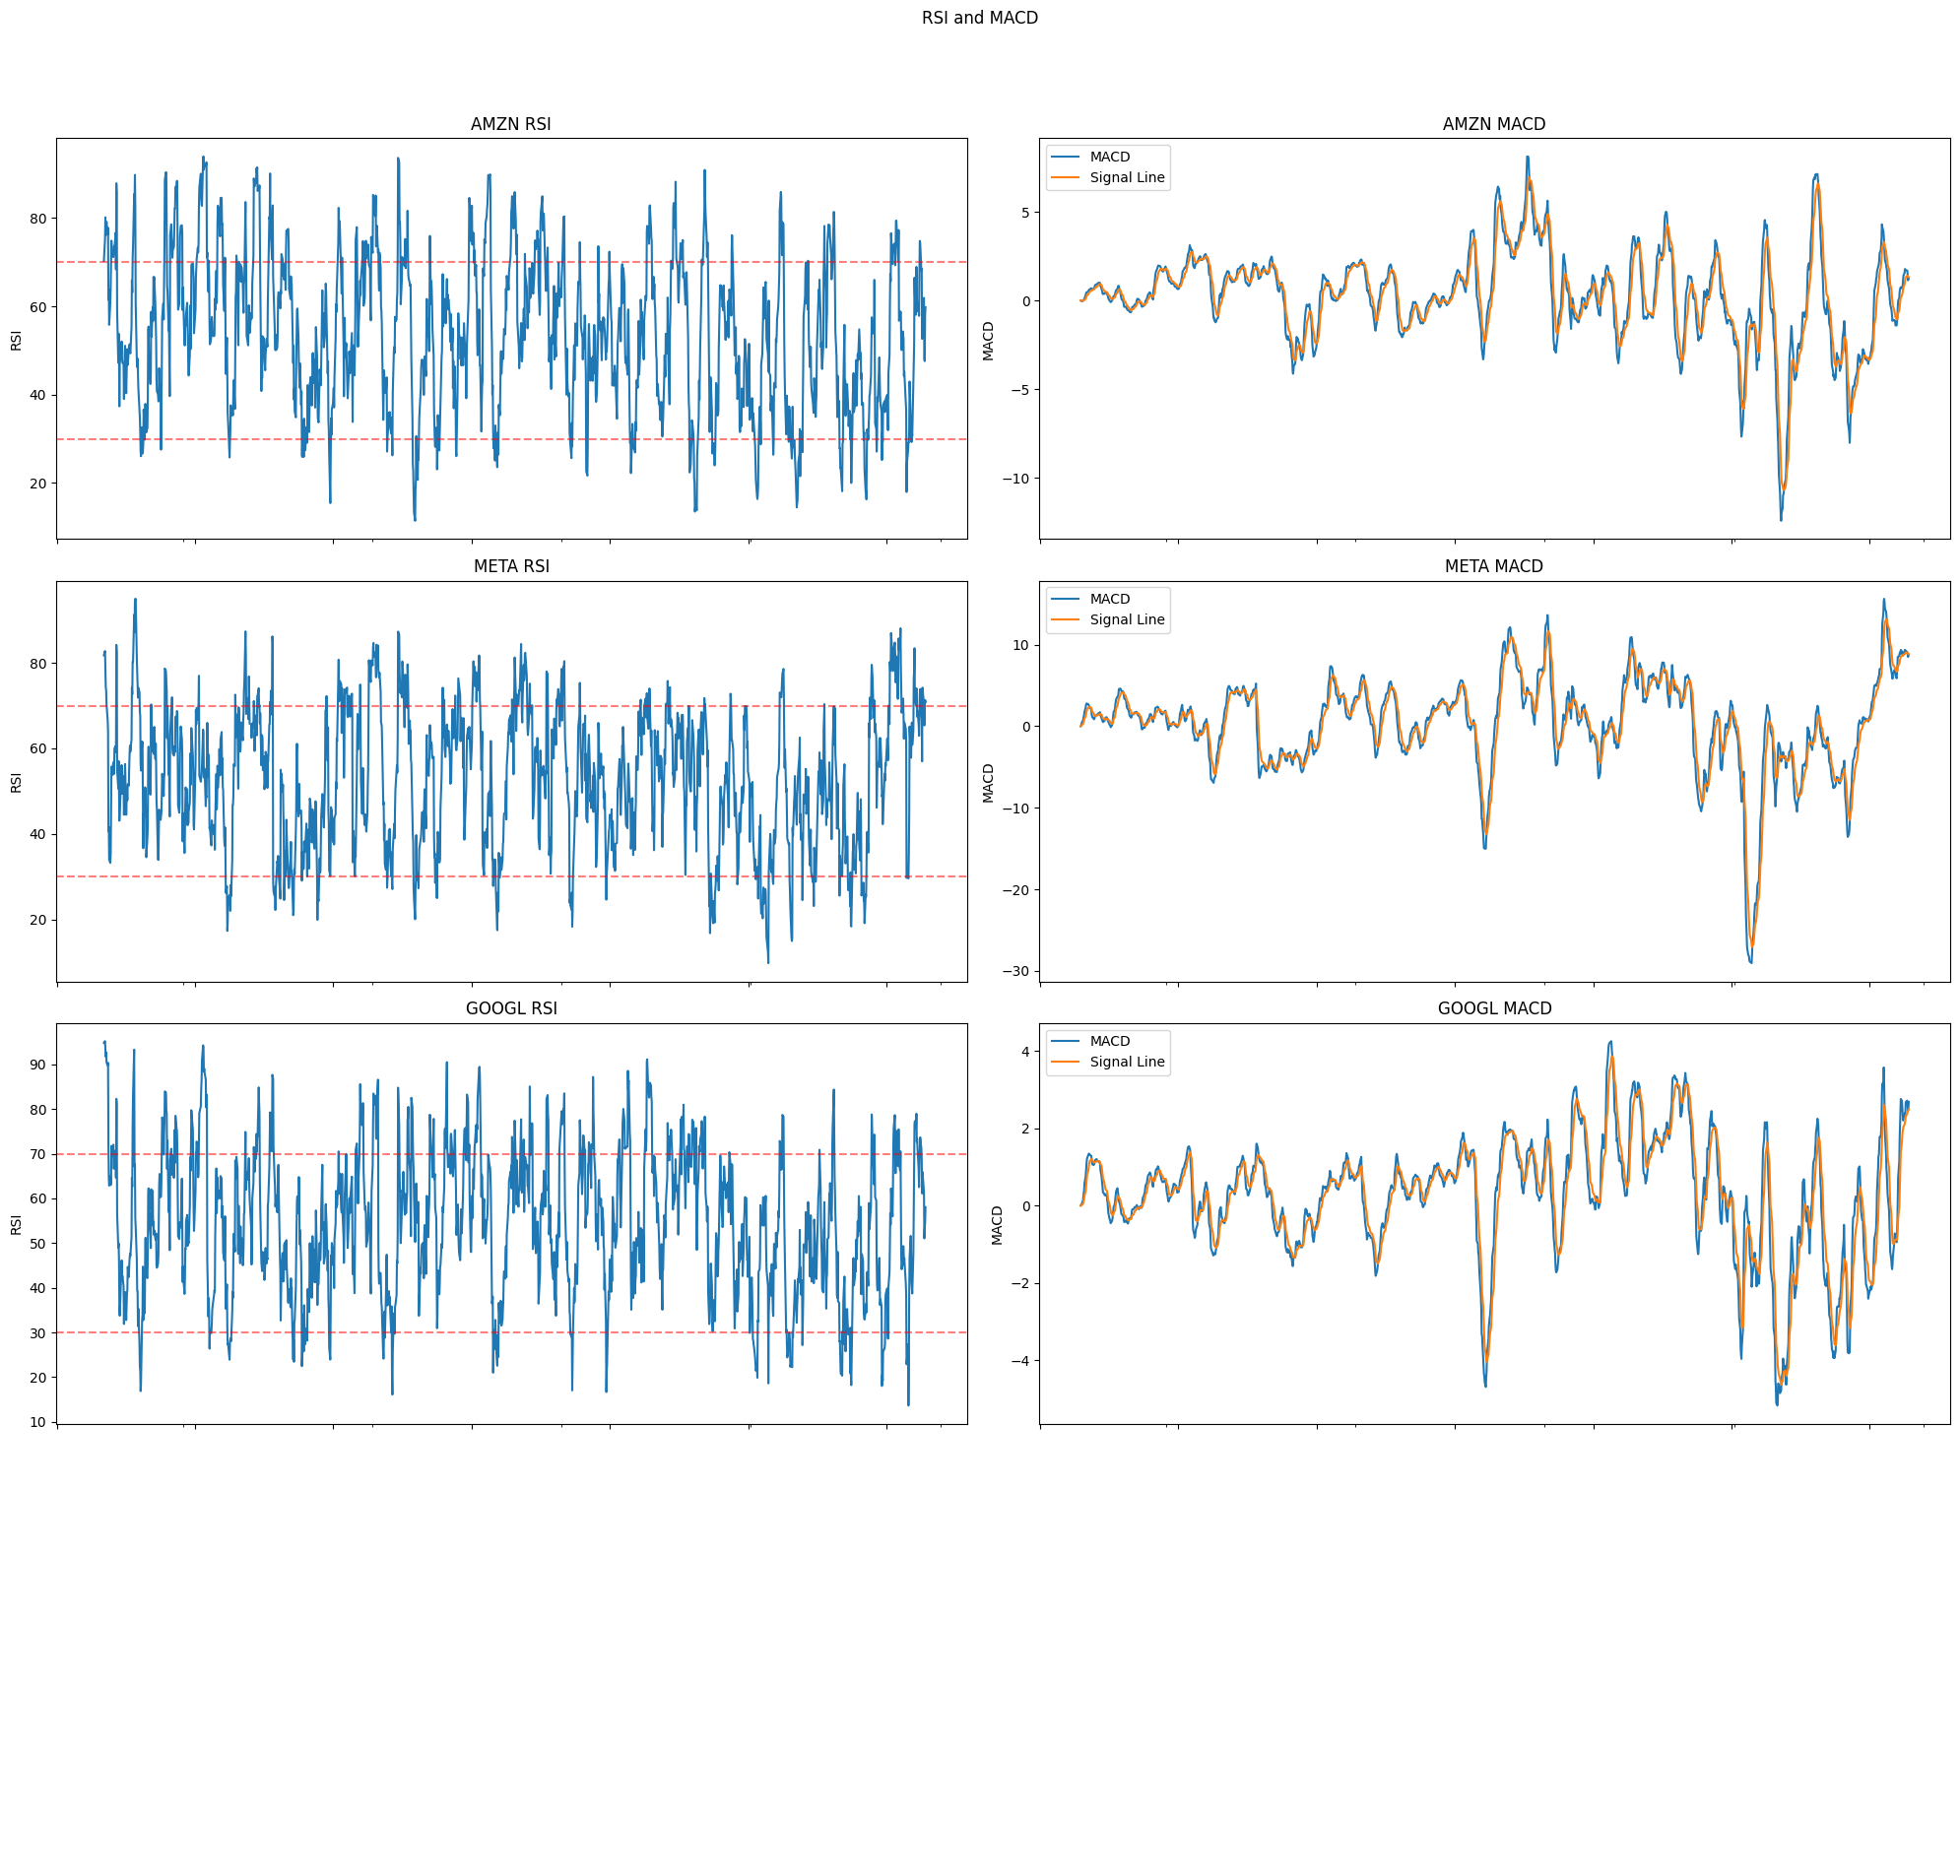

In [40]:
 # Calculate RSI
def rsi(data, period=14):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate MACD
def macd(data, short_period=12, long_period=26, signal_period=9):
    short_ema = data['Close'].ewm(span=short_period, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_period, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line

# Plot RSI and MACD for each company
numrows = len(tickers) // 2 + len(tickers) % 2
numcols = 2

fig, axs = plt.subplots(nrows=numrows*2, ncols=numcols, figsize=(20, 20), sharex=True)
fig.suptitle('RSI and MACD')
axs_flat = axs.flatten()

for i, ticker in enumerate(tickers):
    # RSI plot
    rsi_data = rsi(data[ticker])
    rsi_data.plot(ax=axs_flat[i*2], title=f'{ticker} RSI')
    axs_flat[i*2].axhline(30, color='red', linestyle='--', alpha=0.5)
    axs_flat[i*2].axhline(70, color='red', linestyle='--', alpha=0.5)
    axs_flat[i*2].set_xlabel('Date')
    axs_flat[i*2].set_ylabel('RSI') 

# Remove the extra unused subplot
axs[-1, -2].axis('off')

for i, ticker in enumerate(tickers):
    # MACD plot
    macd_line, signal_line = macd(data[ticker])
    macd_line.plot(ax=axs_flat[i*2+1], title=f'{ticker} MACD', label='MACD')
    signal_line.plot(ax=axs_flat[i*2+1], label='Signal Line')
    axs_flat[i*2+1].set_xlabel('Date')
    axs_flat[i*2+1].set_ylabel('MACD')
    axs_flat[i*2+1].legend()

# Remove the extra unused subplot
axs[-1, -1].axis('off')

# Adjust layout for better spacing
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

This code snippet defines two functions, rsi() and macd(), to calculate the Relative Strength Index (RSI) and Moving Average Convergence Divergence (MACD) indicators for the stock data. It then plots the RSI and MACD values for each ticker in separate subplots.

The rsi() function takes the input stock data and a period (default is 14) to calculate the RSI values. It computes the gains and losses in the stock's closing prices and calculates their average values over the specified period. The RSI is calculated using these average values.

The macd() function calculates the MACD indicator by taking the input stock data, short-period EMA (default is 12), long-period EMA (default is 26), and the signal line period (default is 9). It computes the short and long EMAs and derives the MACD line by subtracting the long EMA from the short EMA. The signal line is calculated as the EMA of the MACD line over the specified signal period.

The code then creates a figure with multiple subplots to visualize the RSI and MACD indicators for each ticker. It loops through the tickers and plots the RSI and MACD values in separate subplots. For the RSI plot, it also adds horizontal lines at 30 and 70 to indicate oversold and overbought levels. The MACD plot includes both the MACD line and the signal line. The subplots are labeled with the ticker name, axis labels, and a legend.

Finally, any unused subplots are removed, and the layout is adjusted for better spacing using fig.tight_layout(). The figure is displayed with plt.show().

In summary, this code snippet calculates the RSI and MACD indicators for the given stock data and visualizes them in separate subplots for each ticker, providing insight into the stocks' momentum and trend-following characteristics.

Relative Strength Index-
1. It is a momentum indicator
2. Basic formula => RSI = 100 - (100 / (1 + RS)) where RS represents the average gain or average loss.
3. The above plot shows the Relative Strength Index for each company using the adjusted close price data. If the RSI value for a company is above 70- it indicated that it is a good time for selling stocks and below 30 indicated good time to consider for buying a stock.
4. From the MACD graphs, we can see the trend of each company's stock momentum, as well as the buy and sell signals that can be derived from the MACD Line and Signal Line crossovers. The MACD Histogram also provides an indication of the strength of the trend, with positive values indicating an uptrend and negative values indicating a downtrend.

In [41]:
def bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band


In [42]:
def plot_bollinger_bands(data, ticker, window=20, num_std=2):
    upper_band, lower_band = bollinger_bands(data, window, num_std)
    plt.figure(figsize=(15, 8))
    plt.plot(data.index, data['Close'], label=f'{ticker} Close Price', color='blue')
    plt.plot(data.index, upper_band, label='Upper Band', color='red')
    plt.plot(data.index, lower_band, label='Lower Band', color='green')
    plt.fill_between(data.index, upper_band, lower_band, color='grey', alpha=0.3)
    plt.title(f'{ticker} Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

Combine the original closing prices with the calculated technical indicators (moving averages, MACD, and RSI) to create a feature set for each stock:

                                Open       High        Low      Close  \
Date                                                                    
2018-01-31 00:00:00-05:00  72.565002  73.628998  72.501999  72.544502   
2018-02-01 00:00:00-05:00  72.250000  72.994003  69.257004  69.500000   
2018-02-02 00:00:00-05:00  73.869499  74.900002  70.699997  71.497498   
2018-02-05 00:00:00-05:00  70.130997  72.948997  66.036003  69.500000   
2018-02-06 00:00:00-05:00  68.072998  72.199501  67.589500  72.141998   

                              Volume  Dividends  Stock Splits      MA_10  \
Date                                                                       
2018-01-31 00:00:00-05:00  128494000        0.0           0.0  68.608250   
2018-02-01 00:00:00-05:00  182276000        0.0           0.0  69.091650   
2018-02-02 00:00:00-05:00  222514000        0.0           0.0  69.768501   
2018-02-05 00:00:00-05:00  229900000        0.0           0.0  70.081950   
2018-02-06 00:00:00-05:00  22133

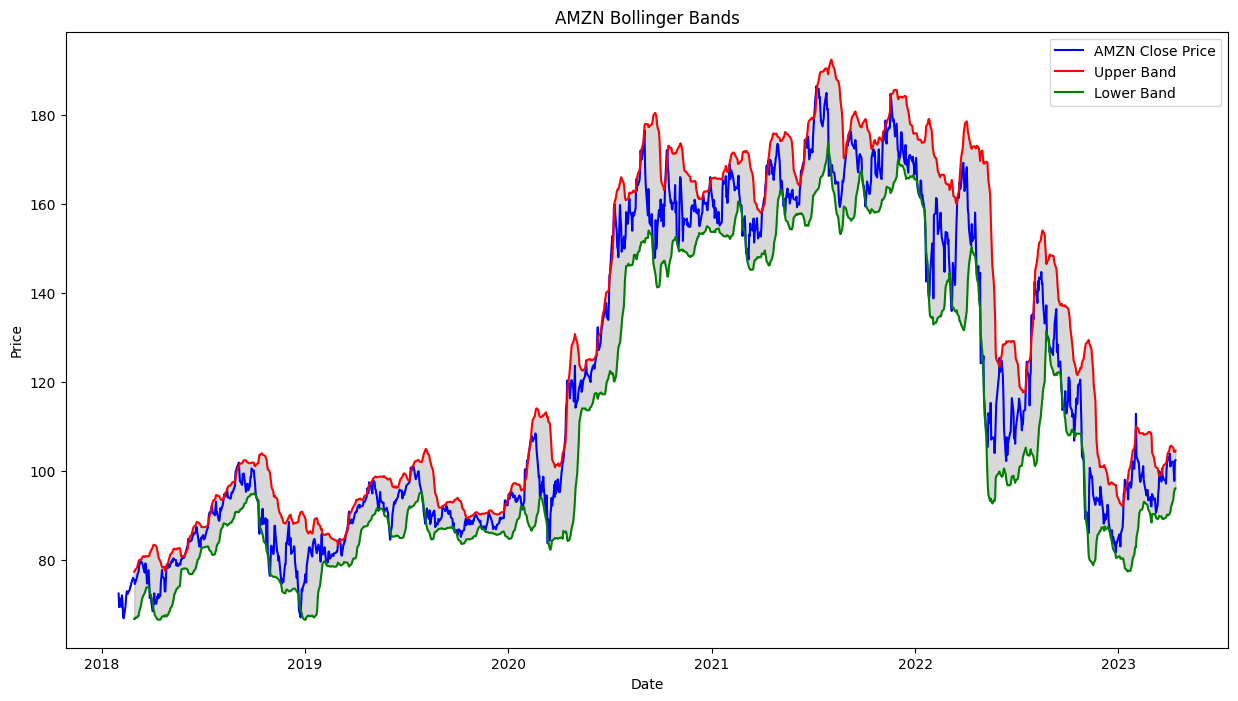

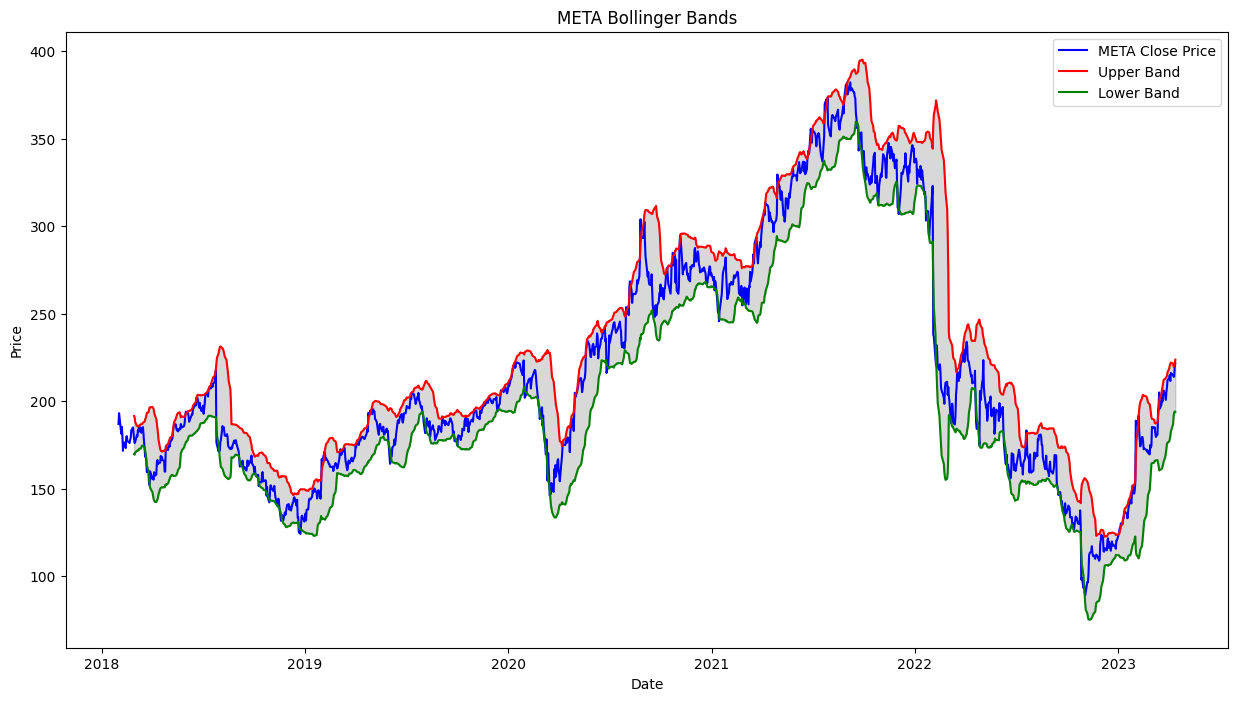

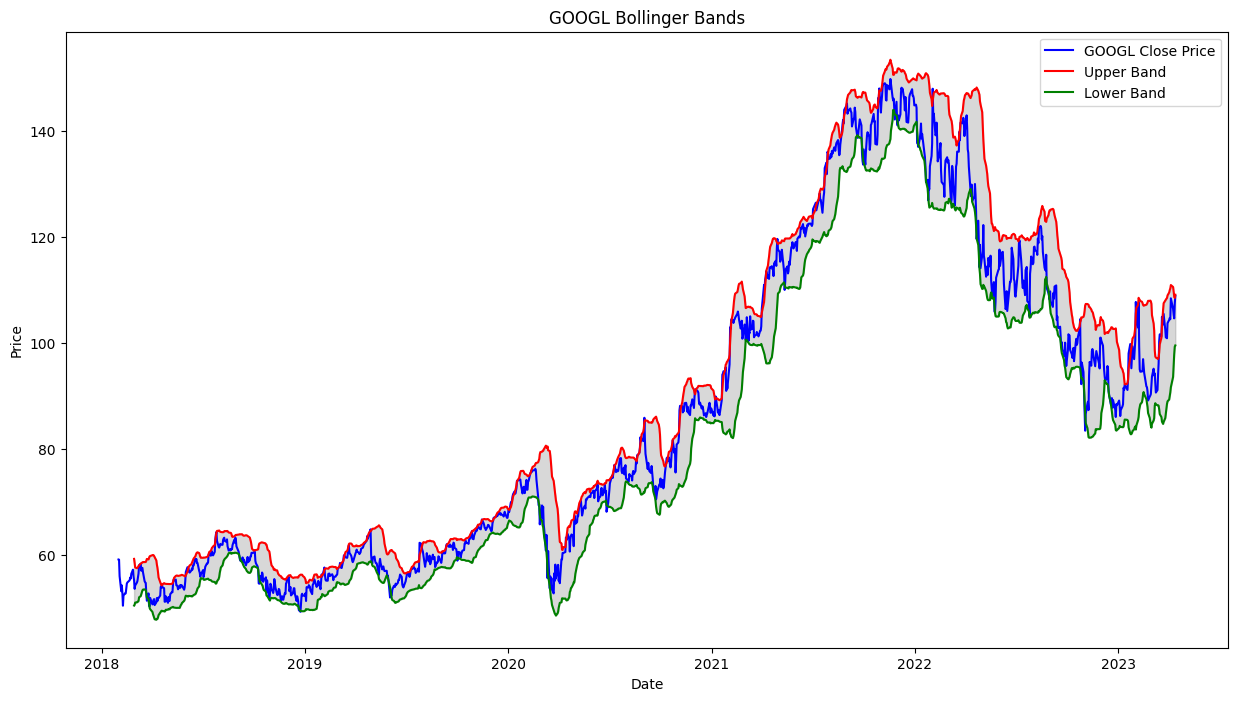

In [43]:
def addMA(data, MA):
    for ma in MA:
        data[f'MA_{ma}'] = data['Close'].rolling(window=ma).mean()
    return data
MA = [10,50,100,200]
#adding moving averages, RSI and MACD to our stock data
featureSets = {}
for ticker in tickers:
    stockFeatures = data[ticker].copy()
    stockFeatures = addMA(stockFeatures, MA)
    stockFeatures['RSI'] = rsi(stockFeatures)
    stockFeatures['MACD'], stockFeatures['Signal Line'] = macd(stockFeatures)
    # Calculate and add Bollinger Bands
    upper_band, lower_band = bollinger_bands(stockFeatures)
    stockFeatures['Upper Band'] = upper_band
    stockFeatures['Lower Band'] = lower_band
    featureSets[ticker] = stockFeatures.dropna()

print(featureSets['AMZN'].head()) 
print(featureSets['META'].head())
print(featureSets['GOOGL'].head())

for ticker in tickers:
    stock_data = featureSets[ticker]
    plot_bollinger_bands(stock_data, ticker)

Implement a function that creates input-output pairs of sequences for each stock using the sliding window approach. The function should take the feature set, lookback window size, and target column (e.g., Opening Price) as input and return input-output pairs (X, y).

In [44]:
def seq(data,lookback, targetCol ='Close'):
    X, y =[],[]
    for i in range (lookback, len(data)):
        X.append(data.iloc[i - lookback:i].values)
        y.append(data.iloc[i][targetCol])
    return np.array(X), np.array(y)

lookback = 60

InputOutput = {}

for ticker in tickers:
    X, y = seq(featureSets[ticker],lookback, targetCol ='Close')
    InputOutput[ticker]= {'X': X, 'y':y}

Normalize the Data

In [45]:
ScalerFeatures = MinMaxScaler()
ScalerResponse = MinMaxScaler()

scaledIO = {}

for ticker in tickers:
    X = InputOutput[ticker]['X']
    y = InputOutput[ticker]['y']
    y = y.reshape(-1, 1)

    # scaling the input features
    sample, timesteps, features = X.shape
    X = X.reshape(sample, -1)
    ScalerFeatures.fit(X)
    X = ScalerFeatures.transform(X)
    X = X.reshape(sample, timesteps, features)

    # scaling response variable
    ScalerResponse.fit(y)
    y = ScalerResponse.transform(y)

    scaledIO[ticker] = {'X': X, 'y': y} 


To perform a train-test split for each stock while maintaining the time series order, you can follow the steps below:

In [46]:
dataSplit = (0.5,0.25,0.25)
Split_Data = {}

for ticker in tickers:
    X = scaledIO[ticker]['X']
    y = scaledIO[ticker]['y']

    train_split = int(X.shape[0] * dataSplit[0])
    valid_split = train_split + int(X.shape[0] * dataSplit[1])

    X_train = X[:train_split]
    y_train = y[:train_split]
    X_val = X[train_split:valid_split]
    y_val = y[train_split:valid_split]
    X_test = X[valid_split:]
    y_test = y[valid_split:]

    Split_Data[ticker] = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val, 'X_test': X_test, 'y_test': y_test}
 

Crosschecking for null values in the dataset

We can see there are no null values in out dataset, now we can proceed to build our model

Processing AMZN.....
Epoch 1/100
20/20 [==============================] - 5s 84ms/step - loss: 0.0221 - val_loss: 0.0064
Epoch 2/100
20/20 [==============================] - 1s 42ms/step - loss: 0.0067 - val_loss: 0.0087
Epoch 3/100
20/20 [==============================] - 1s 43ms/step - loss: 0.0049 - val_loss: 0.0098
Epoch 4/100
20/20 [==============================] - 1s 41ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 5/100
20/20 [==============================] - 1s 42ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 6/100
20/20 [==============================] - 1s 42ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 7/100
20/20 [==============================] - 1s 45ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 8/100
20/20 [==============================] - 1s 45ms/step - loss: 0.0040 - val_loss: 0.0087
Epoch 9/100
20/20 [==============================] - 1s 50ms/step - loss: 0.0039 - val_loss: 0.0071
Epoch 10/100
20/20 [==============================] - 1s 46ms/step - loss: 0.00

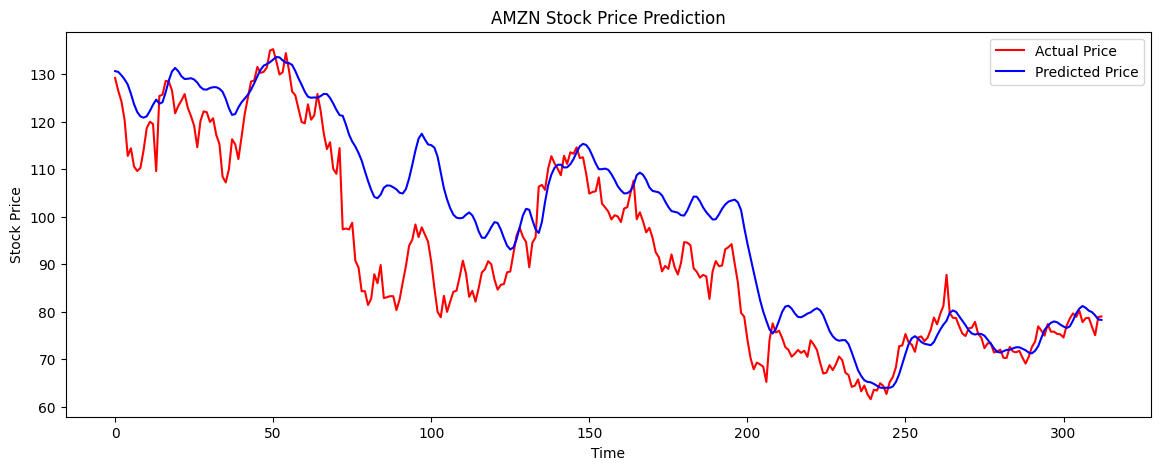

Processing META.....
Epoch 1/100
20/20 [==============================] - 5s 100ms/step - loss: 0.0252 - val_loss: 0.0168
Epoch 2/100
20/20 [==============================] - 1s 58ms/step - loss: 0.0064 - val_loss: 0.0075
Epoch 3/100
20/20 [==============================] - 1s 57ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 4/100
20/20 [==============================] - 1s 58ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 5/100
20/20 [==============================] - 1s 57ms/step - loss: 0.0039 - val_loss: 0.0071
Epoch 6/100
20/20 [==============================] - 1s 58ms/step - loss: 0.0039 - val_loss: 0.0085
Epoch 7/100
20/20 [==============================] - 1s 58ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 8/100
20/20 [==============================] - 1s 60ms/step - loss: 0.0035 - val_loss: 0.0065
Epoch 9/100
20/20 [==============================] - 1s 61ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 10/100
20/20 [==============================] - 1s 62ms/step - loss: 0.0

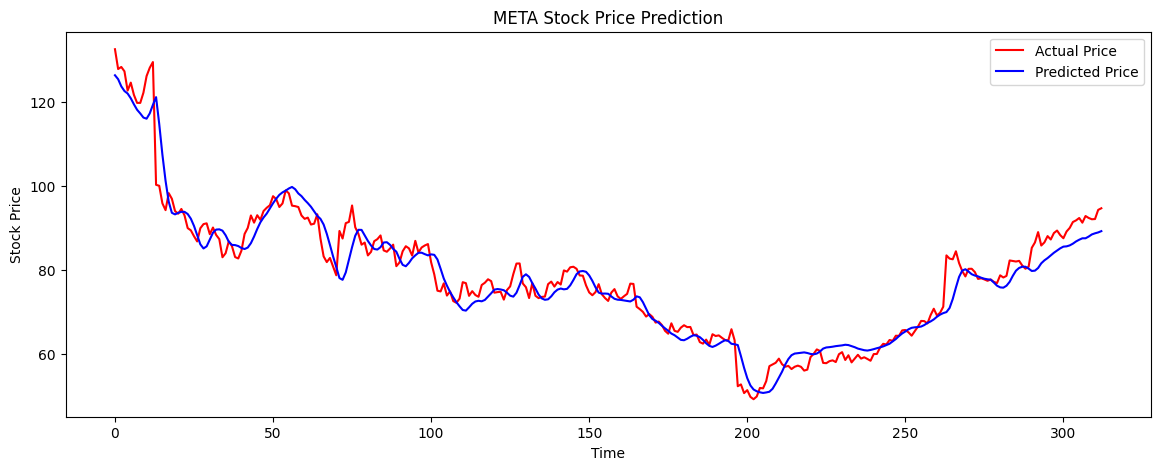

Processing GOOGL.....
Epoch 1/100
20/20 [==============================] - 5s 96ms/step - loss: 0.0079 - val_loss: 0.0499
Epoch 2/100
20/20 [==============================] - 1s 57ms/step - loss: 0.0018 - val_loss: 0.0315
Epoch 3/100
20/20 [==============================] - 1s 55ms/step - loss: 0.0012 - val_loss: 0.0317
Epoch 4/100
20/20 [==============================] - 1s 55ms/step - loss: 0.0012 - val_loss: 0.0130
Epoch 5/100
20/20 [==============================] - 1s 56ms/step - loss: 0.0013 - val_loss: 0.0142
Epoch 6/100
20/20 [==============================] - 1s 55ms/step - loss: 0.0011 - val_loss: 0.0133
Epoch 7/100
20/20 [==============================] - 1s 56ms/step - loss: 9.5974e-04 - val_loss: 0.0238
Epoch 8/100
20/20 [==============================] - 1s 55ms/step - loss: 8.7159e-04 - val_loss: 0.0152
Epoch 9/100
20/20 [==============================] - 1s 55ms/step - loss: 9.4200e-04 - val_loss: 0.0246
Epoch 10/100
20/20 [==============================] - 1s 55ms/step

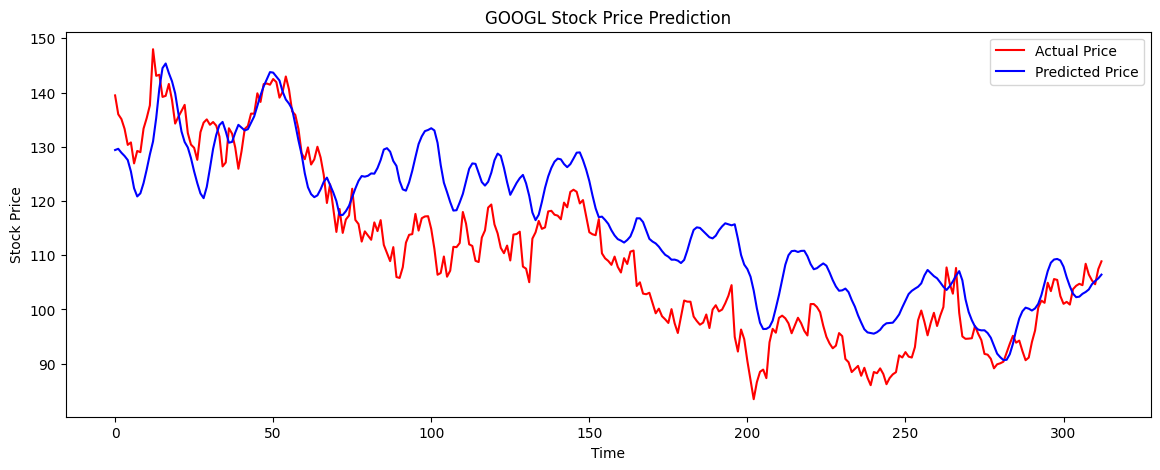

In [47]:
def lstm_model(input_shape, units, dropout_rate, layers):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
        elif i == layers - 1:
            model.add(LSTM(units=units))
        else:
            model.add(LSTM(units=units, return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    return model


layers = 3
units = 64
dropout_rate = 0.3
epochs = 50
batch_size = 32

for ticker in tickers:
    print(f'Processing {ticker}.....')
    # Create and compile the model
    model = lstm_model((lookback, Split_Data[ticker]['X_train'].shape[2]), units, dropout_rate, layers)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    history = model.fit(Split_Data[ticker]['X_train'], Split_Data[ticker]['y_train'], epochs=100, batch_size=32,
                        validation_data=(Split_Data[ticker]['X_val'], Split_Data[ticker]['y_val']))
    # Make predictions
    predictions = model.predict(Split_Data[ticker]['X_test'])
    predictions = ScalerResponse.inverse_transform(predictions)
    # Calculate error metrics
    rmse = sqrt(mean_squared_error(Split_Data[ticker]['y_test'], predictions))
    mae = mean_absolute_error(Split_Data[ticker]['y_test'], predictions)
 
    print(f"{ticker} RMSE: {rmse}")
    print(f"{ticker} MAE: {mae}") 
    
    # Plot actual vs predicted values
    plt.figure(figsize=(14, 5))
    plt.plot(ScalerResponse.inverse_transform(Split_Data[ticker]['y_test']), color='red', label='Actual Price')
    plt.plot(predictions, color='blue', label='Predicted Price')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()  

10/10 [==============================] - 0s 18ms/step


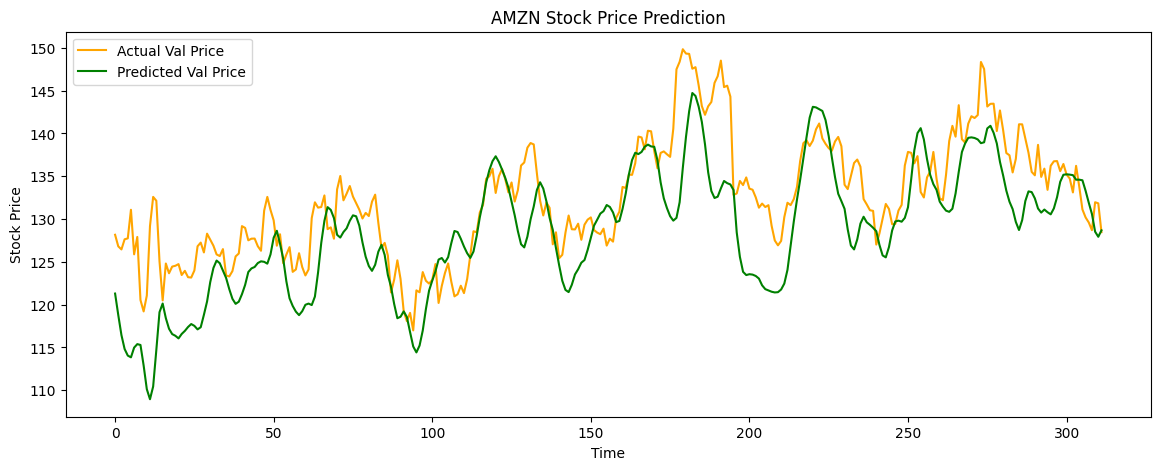

10/10 [==============================] - 0s 17ms/step


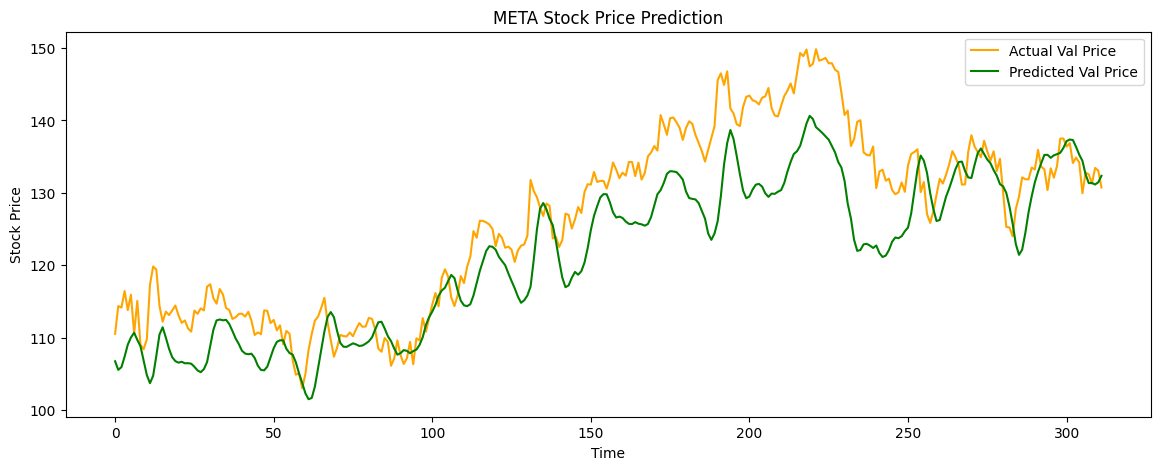

10/10 [==============================] - 0s 20ms/step


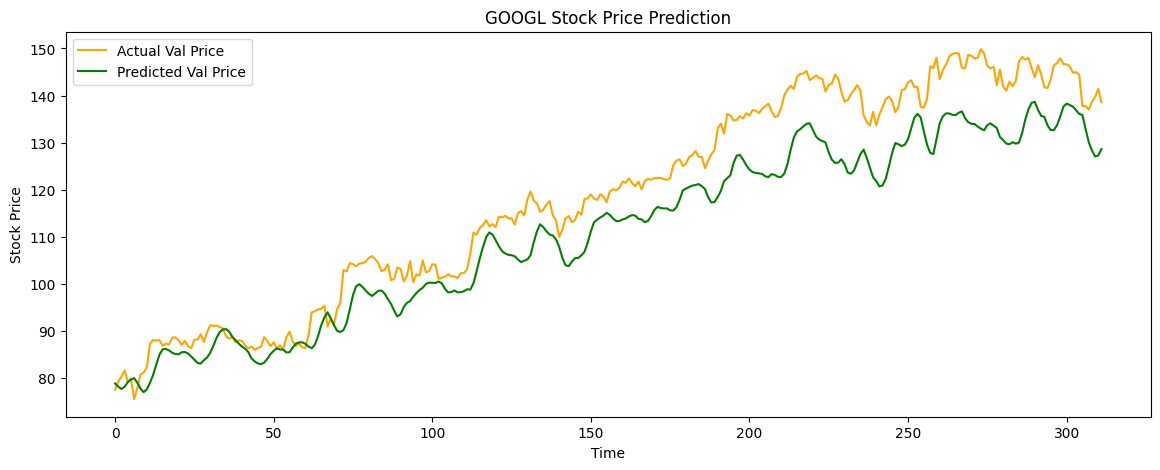

In [48]:
 
for ticker in tickers:
    # Make predictions
    
    valid_predictions = model.predict(Split_Data[ticker]['X_val'])
    valid_predictions = ScalerResponse.inverse_transform(valid_predictions)
    
    # Plot actual vs predicted values
    plt.figure(figsize=(14, 5))
    
    plt.plot(ScalerResponse.inverse_transform(Split_Data[ticker]['y_val']), color='orange', label='Actual Val Price')
    plt.plot(valid_predictions, color='green', label='Predicted Val Price')
    
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


In [49]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 60, 64)            20736     
                                                                 
 dropout_24 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_25 (LSTM)              (None, 60, 64)            33024     
                                                                 
 dropout_25 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_26 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                

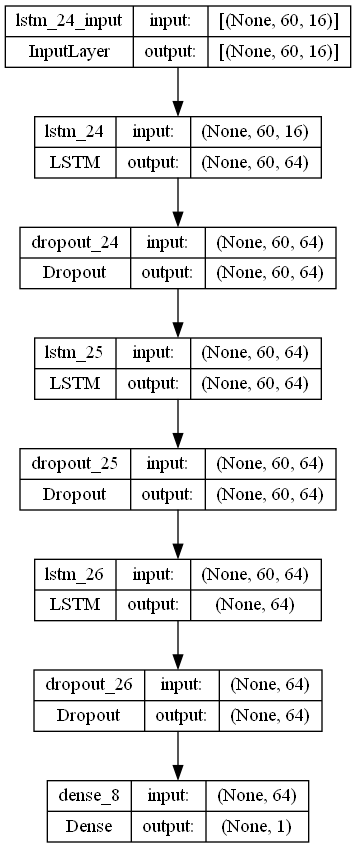

In [50]:
from keras.utils import plot_model

# Visualize the model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Processing AMZN.....
AMZN RMSE: 53.439193811470076
AMZN MAE: 46.43099136642822


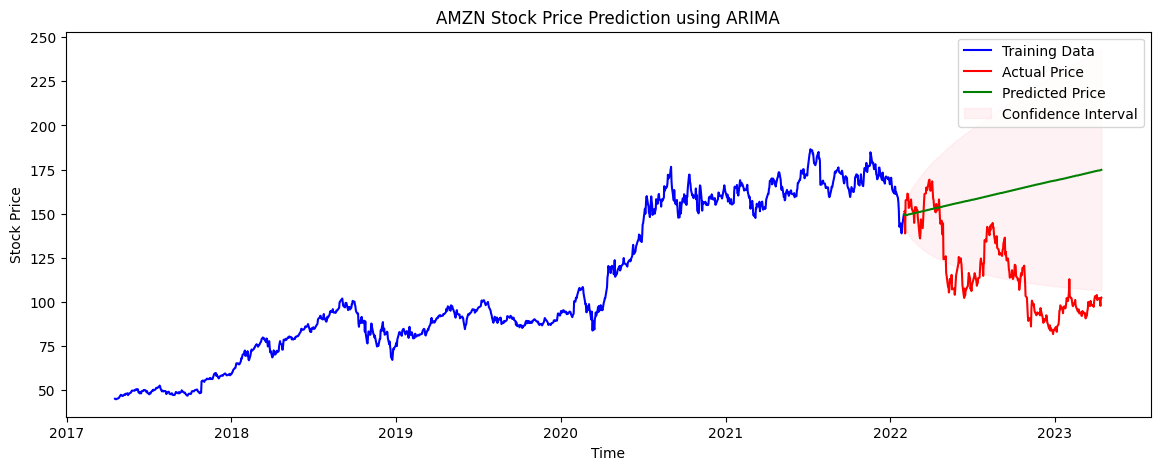

Processing META.....
META RMSE: 169.17745344859708
META MAE: 163.14986311911719


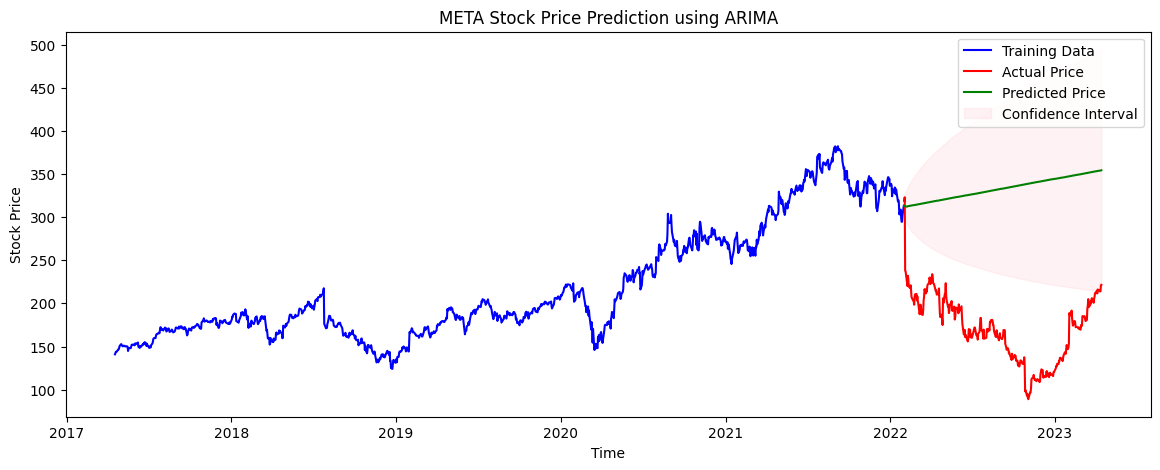

Processing GOOGL.....
GOOGL RMSE: 42.66849996731873
GOOGL MAE: 37.60164190169073


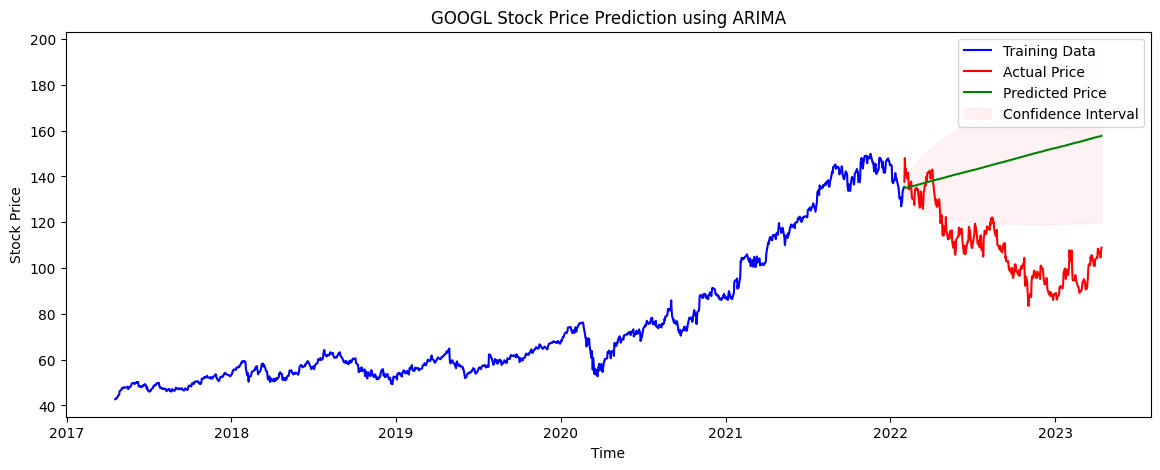

In [58]:
import pmdarima as pm

# Function to fit and predict the ARIMA model
def fit_predict_arima(data, train_split, test_split, order):
    train_data = data[:train_split]
    test_data = data[train_split:train_split + test_split]

    model = pm.ARIMA(order=order)
    model.fit(train_data)

    forecast, conf_int = model.predict(n_periods=test_split, return_conf_int=True)

    return forecast, conf_int

arima_order = (5, 1, 0)
train_split = int(len(data['AMZN']) * 0.8)
test_split = len(data['AMZN']) - train_split

for ticker in tickers:
    print(f'Processing {ticker}.....')
    
    # Using only the closing prices for ARIMA model
    closing_prices = data[ticker]['Close'].values
    
    forecast, conf_int = fit_predict_arima(closing_prices, train_split, test_split, arima_order)

    # Calculate error metrics
    rmse = sqrt(mean_squared_error(data[ticker]['Close'].values[train_split:train_split + test_split], forecast))
    mae = mean_absolute_error(data[ticker]['Close'].values[train_split:train_split + test_split], forecast)

    print(f"{ticker} RMSE: {rmse}")
    print(f"{ticker} MAE: {mae}")

    # Plot actual vs predicted values
    plt.figure(figsize=(14, 5))
    plt.plot(data[ticker].index[:train_split], data[ticker]['Close'].values[:train_split], color='blue', label='Training Data')
    plt.plot(data[ticker].index[train_split:train_split + test_split], data[ticker]['Close'].values[train_split:train_split + test_split], color='red', label='Actual Price')
    plt.plot(data[ticker].index[train_split:train_split + test_split], forecast, color='green', label='Predicted Price')
    plt.fill_between(data[ticker].index[train_split:train_split + test_split], conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.2, label='Confidence Interval')
    plt.title(f'{ticker} Stock Price Prediction using ARIMA')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
